In [ ]:
import json
import re

# Function to parse multiple BibTeX-like entries in a file and output as JSON
def parse_bibtex_to_json(input_file_path, output_file_path):
    # Read the entire file content
    with open(input_file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    
    # Split the text into individual entries
    entries = re.split(r"(?=Reference Type:)", text)
    data_list = []
    
    # Regex patterns for each field
    patterns = {
        "reference_type": r"Reference Type:\s+(.+)",
        "author": r"Author:\s+(.+)",
        "year": r"Year:\s+(\d+)",
        "title": r"Title:\s+(.+)",
        # "institution": r"%B\s+(.+)",
        "volume": r"Volume:\s+(.+)",
        "issue": r"Issue:\s+(.+)",
        "pages": r"Pages:\s+(\d+)",
        "keywords": r"Keywords:\s+(.+)",
        "abstract": r"Abstract:\s+(.+)",
        "ibsn": r"ISSN:\s+(.+)"
    }


    # Process each entry
    for entry in entries:
        entry_data = {}
        
        # Extract each field using regex
        for key, pattern in patterns.items():
            match = re.search(pattern, entry)
            if match:
                entry_data[key] = match.group(1).strip()
        
        # Special handling for keywords to create a structured list
        if "keywords" in entry_data:
            keyword_pairs = entry_data["keywords"].split(",")
            entry_data["keywords"] = [
                {
                    "en": keyword.split("(")[0].strip(),
                    "ko": keyword.split("(")[1].strip(")")
                } for keyword in keyword_pairs if "(" in keyword
            ]
        
        # Convert page_count to integer
        if "page_count" in entry_data:
            entry_data["page_count"] = int(entry_data["page_count"])
        
        # Add the entry data to the list if it has content
        if entry_data:
            data_list.append(entry_data)

    # Write the list of entries as JSON array to the output file
    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        json.dump(data_list, output_file, ensure_ascii=False, indent=4)

    return data_list

In [8]:
# File path to the input text file
input_file_path = './102_annotated_with_keyword.txt'
output_file_path = "./structured_annotation_.json" 

# Run the function and print the result
annotations = parse_bibtex_to_json(input_file_path, output_file_path)

linguistic  landscape,  street-level  images,  scene  text  detection  and  recognition,  urban  analytics
공공언어
언어경관
言語景&#35251
World Englishes, linguistic landscape, multiple nucleic model, urban sprawl, urban development, suburbanization
linguistic landscape
기호론
Language Landscape


In [9]:

import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):

    if "<br />" in text:
        text = text.split("<br />", 1)[1]


    # Regular expression to remove Korean and Chinese characters
    # \u4e00-\u9fff is the Unicode range for Chinese characters
    # \uac00-\ud7af is the Unicode range for Hangul (Korean characters)
    text = re.sub(r'[\u4e00-\u9fff\u3040-\u30ff\uac00-\ud7af]+', '', text)
    
    # Remove extra spaces, unwanted punctuation, and symbols
    text = re.sub(r'\s+', ' ', text) # Replace multiple spaces with a single space
    text = text.lower().strip() # Remove leading/trailing spaces. Lowercasing


    # Remove stop words
    stop_words = set(ENGLISH_STOP_WORDS)
    stop_words.update(['also'])  # Add custom stop words
    
    # Lemmatization to reduce words to their base form
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    cleaned_text = ' '.join([lemmatizer.lemmatize(word) for word in words if word not in stop_words]) #only nouns. 

    
    return cleaned_text

In [10]:
from pprint import pprint
from langdetect import detect

abstracts = []

# add english abstracts
for i, annotation in enumerate(annotations):
    abstract = annotation.get("abstract")
    if abstract is not None and detect(abstract) == "en":
        english_abstracts = preprocess_text(abstract)
        if len(english_abstracts) > 10:

            annotations[i]["english_abstract"] = english_abstracts


In [11]:
from keybert import KeyBERT

# Initialize KeyBERT
kw_model = KeyBERT()

# Define a function to get the top n% keywords using KeyBERT
def get_top_keywords(abstract, top_percent=0.9, max_keywords=7):
    # Extract keywords with KeyBERT, returning keywords with scores
    keywords = kw_model.extract_keywords(abstract, keyphrase_ngram_range=(1, 2), stop_words='english')
    # Calculate the number of top keywords to keep: top n% or max p, whichever is smaller
    top_n = min(max_keywords, max(1, int(top_percent * len(keywords))))
    # Select the top keywords
    top_keywords = keywords[:top_n]
    return top_keywords

c:\Users\tatia\anaconda3\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [12]:
for i, annotation in enumerate(annotations):
    if (annotation.get("keywords") is None or len(annotation.get("keywords")) == 0) and annotation.get("english_abstract") is not None:
        keywords = get_top_keywords(annotation.get("english_abstract"))
        annotations[i]["keywords"] = [{"en": keyword[0]} for keyword in keywords]
        

In [13]:

output_file_path = "./structured_annotation.json" 
with open(output_file_path, 'w', encoding='utf-8') as output_file:
    json.dump(annotations, output_file, ensure_ascii=False, indent=4)

In [14]:
annotations[5].get("keywords")

[{'en': 'landscape mongolia'},
 {'en': 'change mongolia'},
 {'en': 'mongolia traditional'},
 {'en': 'ger mongolia'}]

In [15]:
keywords_list = []

for annotation in annotations:
    keywords_annotation = annotation.get("keywords")
    if keywords_annotation:
        keywords = [keyword_annotation.get("en") for keyword_annotation in keywords_annotation if not bool(re.search(r'\d', keyword_annotation.get("en")))] #remove numbers

        keywords_list.append(keywords)



In [16]:
import pandas as pd
from collections import defaultdict
from itertools import combinations

def build_cooccurrence_matrix(corpus):

    # Initialize a dictionary to store co-occurrence counts
    cooccurrence_counts = defaultdict(int)

    # Iterate over each document in the corpus
    for tokens in corpus:
        # Generate all unique pairs of words in the document
        word_pairs = combinations(set(tokens), 2)
        # word_pairs = list(word_pairs) + [(word, word) for word in tokens]  # Add self-co-occurrence
        word_pairs = list(word_pairs)
        
        # Count each co-occurrence
        for word1, word2 in word_pairs:
            cooccurrence_counts[tuple(sorted([word1, word2]))] += 1

    # Get a sorted list of unique words
    unique_words = sorted(set(word for tokens in corpus for word in tokens))
    
    # Create a DataFrame for the co-occurrence matrix
    matrix = pd.DataFrame(0, index=unique_words, columns=unique_words)

    # Fill the matrix with co-occurrence counts
    for (word1, word2), count in cooccurrence_counts.items():
        matrix.loc[word1, word2] = count
        matrix.loc[word2, word1] = count  # Ensure symmetry

    return matrix


def preprocess_cooccurrence_matrix(cooccurrence_matrix, top_k):

    # Calculate the total co-occurrence for each word (sum of rows or columns)
    total_cooccurrence = cooccurrence_matrix.sum(axis=1)

    # Get the top words based on the total co-occurrence
    top_occurrences = total_cooccurrence.sort_values(ascending = False).head(top_k)

    top_words = top_occurrences.index

    # Filter the co-occurrence matrix to include only the top words
    filtered_matrix = cooccurrence_matrix.loc[top_words, top_words]

    # Normalize to get the average occurence per abstract
    # normalized_filtered_matrix = filtered_matrix / len(abstracts)
    normalized_filtered_matrix = filtered_matrix #no normalization

    return normalized_filtered_matrix

In [17]:
pprint(keywords_list)

[['multilingual signage',
  'signage internationalized',
  'international students',
  'signage international'],
 ['multilingualism shaping',
  'internationalizing universities',
  'multilingualism',
  'internationalization higher'],
 ['landscape mongolia',
  'change mongolia',
  'mongolia traditional',
  'ger mongolia'],
 ['language landscape',
  'languages regional',
  'change language',
  'available language'],
 ['japanese consumers',
  'japan sociolinguistic',
  'korean culture',
  'korean japanese'],
 ['embracing māori', 'māori settled', 'settler māori', 'māori environmental'],
 ['cultural identity',
  'linguistic landscape',
  'identity korea',
  'multicultural interaction'],
 ['signboard japanese',
  'japanese signboards',
  'japanese signboard',
  'japanese sign'],
 ['signage predominantly', 'store sign', 'signage', 'sign vicinity'],
 ['multilingualism korean',
  'multilingualism prevalence',
  'phenomenon multilingualism',
  'investigates multilingual'],
 ['ikuno korea', 'kore

In [18]:
top_k = 15

# Build and display the co-occurrence matrix
cooccurrence_matrix_keywords = build_cooccurrence_matrix(keywords_list)
normalized_filtered_matrix_keywords = preprocess_cooccurrence_matrix(cooccurrence_matrix_keywords, top_k)

In [19]:
from IPython.display import display, HTML
display(HTML(normalized_filtered_matrix_keywords.to_html()))

In [20]:
# Create a list to store pairs and their frequencies
pairs = []

# Iterate through the upper triangle of the matrix to get unique pairs
for i in range(len(cooccurrence_matrix_keywords)):
    for j in range(i + 1, len(cooccurrence_matrix_keywords)):
        keyword1 = cooccurrence_matrix_keywords.index[i]
        keyword2 = cooccurrence_matrix_keywords.columns[j]
        frequency = cooccurrence_matrix_keywords.iloc[i, j]
        if frequency > 0:  # Optional: Include only non-zero co-occurrences
            pairs.append(((keyword1, keyword2), frequency))

# Sort pairs by frequency in descending order
sorted_pairs = sorted(pairs, key=lambda x: x[1], reverse=True)

# Display the most frequent pairs
print("Most Frequent Keyword Pairs:\n")
for pair, freq in sorted_pairs:
    print(f"{pair}: {freq}")

Most Frequent Keyword Pairs:

('change linguistic', 'cultural changes'): 2
('change linguistic', 'korean language'): 2
('change linguistic', 'signage chinese'): 2
('cultural changes', 'korean language'): 2
('cultural changes', 'signage chinese'): 2
('internationalization higher', 'internationalizing universities'): 2
('internationalization higher', 'multilingualism'): 2
('internationalization higher', 'multilingualism shaping'): 2
('internationalizing universities', 'multilingualism'): 2
('internationalizing universities', 'multilingualism shaping'): 2
('japanese signboard', 'signboard japanese'): 2
('korean language', 'signage chinese'): 2
('multilingualism', 'multilingualism shaping'): 2
('advertizing city', 'landscape changes'): 1
('advertizing city', 'outdoor advertising'): 1
('advertizing city', 'outdoor advertizing'): 1
('alleys signboard', 'sign chinatown'): 1
('alleys signboard', 'sign language'): 1
('alleys signboard', 'signboard daelim'): 1
('analyze japanese', 'colonializati

In [21]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# import mplfonts
# mplfonts.use_font('Source Han Sans')

def display_heatmap(normalized_filtered_matrix, title):
    # Create a mask to display only the upper triangular part of the matrix
    mask = np.triu(np.ones_like(normalized_filtered_matrix, dtype=bool), k=0)

    # Visualize the reduced matrix
    plt.figure(figsize=(10, 8))

    linecolor = sns.color_palette("light:#666666").as_hex()[0]  # Hex code for light grey
    sns.heatmap(normalized_filtered_matrix, cmap="magma_r", annot=True, cbar=False, square=True, mask = mask, linecolor=linecolor, linewidths=0.5)

    plt.gca().invert_yaxis()

    # Add labels and title
    plt.title(title)
    plt.xlabel("Words")
    plt.ylabel("Words")

    # Show plot
    plt.show()

In [22]:

title_keywords = f"Word co-occurrence matrix heatmap per abstract keywords (top {top_k})"
display_heatmap(normalized_filtered_matrix_keywords, title_keywords)

In [23]:
import networkx as nx
import matplotlib.pyplot as plt
import textwrap



def create_cooccurrence_network(cooccurrence_matrix, threshold=15):
    # Create a new graph
    G = nx.Graph()
    
    # Loop over all pairs of words in the matrix
    for word1 in cooccurrence_matrix.columns:
        for word2 in cooccurrence_matrix.index:
            # Only consider edges where the co-occurrence value is above the threshold
            cooccurrence_value = cooccurrence_matrix.loc[word2, word1]
            if cooccurrence_value >= threshold and word1 != word2:
                # Add an edge with the co-occurrence value as the weight
                G.add_edge(word1, word2, weight=cooccurrence_value)
    
    return G

def plot_pretty_cooccurrence_network(G, title):
    plt.figure(figsize=(12, 10))

    # Node size based on degree (more connections -> bigger node)
    node_size = [100 * G.degree(node) for node in G.nodes]

    # Normalize edge weights for edge width scaling
    max_weight = max(nx.get_edge_attributes(G, 'weight').values())
    min_weight = min(nx.get_edge_attributes(G, 'weight').values())
    edge_width = [(G[u][v]['weight'] - min_weight) / (max_weight - min_weight + 1e-6) * 5 + 0.5 for u, v in G.edges]

    # Colors based on degree (more central nodes get warmer colors)
    node_color = [G.degree(node) for node in G.nodes]

    # Layout for better visualization
    pos = nx.spring_layout(G, k=1.75, iterations=50, seed=42)

    # Wrap labels to two lines
    labels = {node: '\n'.join(textwrap.wrap(node, width=15)) for node in G.nodes}

    # Draw the nodes with a color map
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.viridis, alpha=0.8)

    # Draw the edges with width based on weight
    edges = nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.6, edge_color='gray')

    # Draw the wrapped labels
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color='black', font_weight='bold')

    # Draw edge labels (weight values)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    if len(edge_labels) < 50:  # Only show edge labels for small graphs
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Add a title
    plt.title(title, fontsize=16)

    # Hide axes
    plt.axis('off')

    # Display the plot
    plt.show()



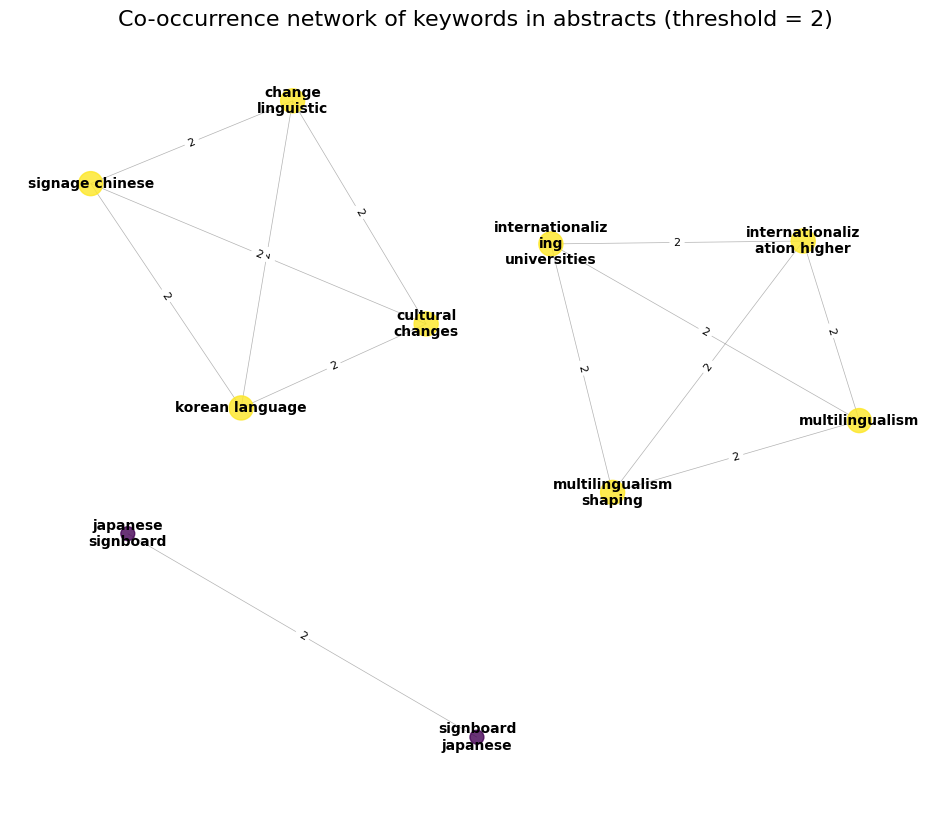

In [24]:
threshold = 2
G = create_cooccurrence_network(cooccurrence_matrix_keywords, threshold=threshold)
title = f"Co-occurrence network of keywords in abstracts (threshold = {threshold})"
plot_pretty_cooccurrence_network(G, title)

In [25]:
import pandas as pd
from pyvis.network import Network
import networkx as nx
import community.community_louvain as community  # Updated import for Louvain

def create_pyvis_network_with_clusters(cooccurrence_matrix, threshold=1):
    # Convert co-occurrence matrix to a NetworkX graph
    G = nx.Graph()
    
    # Track nodes that have edges meeting the threshold
    connected_nodes = set()
    
    # Add edges from co-occurrence matrix where weight >= threshold
    for i in range(len(cooccurrence_matrix.columns)):
        for j in range(i+1, len(cooccurrence_matrix.columns)):
            weight = cooccurrence_matrix.iloc[i, j]
            if weight >= threshold:
                G.add_edge(cooccurrence_matrix.columns[i], cooccurrence_matrix.columns[j], weight=int(weight))
                connected_nodes.add(cooccurrence_matrix.columns[i])
                connected_nodes.add(cooccurrence_matrix.columns[j])

    # Detect clusters using Louvain method
    partition = community.best_partition(G)  # Returns a dict {node: cluster_id}
    
    # Assign unique colors for each cluster
    unique_clusters = set(partition.values())
    color_map = {cluster_id: f"hsl({i * 360 / len(unique_clusters)}, 70%, 60%)" 
                 for i, cluster_id in enumerate(unique_clusters)}
    
    # Create the pyvis network
    net = Network(height="750px", width="100%", notebook=True, cdn_resources='in_line')
    net.set_options("""
        var options = {
            "nodes": {
                "font": {"size": 18, "color": "#34495e"},
                "scaling": {"min": 5, "max": 25}
            },
            "edges": {
                "color": {"inherit": "both"},
                "smooth": false
            },
            "physics": {
                "barnesHut": {
                    "gravitationalConstant": -2500,
                    "centralGravity": 0.3,
                    "springLength": 100
                }
            }
        }
    """)

    # Add only connected nodes with cluster-based colors
    for word in connected_nodes:
        cluster_id = partition.get(word, 0)
        color = color_map[cluster_id]
        net.add_node(word, label=word, title=word, color=color)

    # Add edges with weights for visualization
    for edge in G.edges(data=True):
        node1, node2, data = edge
        weight = data['weight']
        if weight >= threshold:
            net.add_edge(node1, node2, value=weight, title=f"Co-occurrence: {weight}")

    # Visualize the network
    net.show("co_occurrence_network_with_clusters.html")


In [26]:
import pandas as pd
from pyvis.network import Network
import networkx as nx
import community.community_louvain as community  # Updated import for Louvain

def create_pyvis_network_with_clusters(cooccurrence_matrix, threshold=1, title="Co-occurrence Network", 
                                       caption="This network shows clusters of frequently co-occurring terms."):
    # Convert co-occurrence matrix to a NetworkX graph
    G = nx.Graph()
    
    # Track nodes that have edges meeting the threshold
    connected_nodes = set()
    
    # Add edges from co-occurrence matrix where weight >= threshold
    for i in range(len(cooccurrence_matrix.columns)):
        for j in range(i+1, len(cooccurrence_matrix.columns)):
            weight = cooccurrence_matrix.iloc[i, j]
            if weight >= threshold:
                G.add_edge(cooccurrence_matrix.columns[i], cooccurrence_matrix.columns[j], weight=int(weight))
                connected_nodes.add(cooccurrence_matrix.columns[i])
                connected_nodes.add(cooccurrence_matrix.columns[j])

    # Detect clusters using Louvain method
    partition = community.best_partition(G)  # Returns a dict {node: cluster_id}
    
    # Assign unique colors for each cluster
    unique_clusters = set(partition.values())
    color_map = {cluster_id: f"hsl({i * 360 / len(unique_clusters)}, 70%, 60%)" 
                 for i, cluster_id in enumerate(unique_clusters)}
    
    # Create the pyvis network
    net = Network(height="750px", width="100%", notebook=True, cdn_resources='in_line')
    net.set_options("""
        var options = {
            "nodes": {
                "font": {"size": 18, "color": "#34495e"},
                "scaling": {"min": 5, "max": 25}
            },
            "edges": {
                "color": {"inherit": "both"},
                "smooth": false
            },
            "physics": {
                "barnesHut": {
                    "gravitationalConstant": -2500,
                    "centralGravity": 0.3,
                    "springLength": 100
                }
            }
        }
    """)

    # Add only connected nodes with cluster-based colors
    for word in connected_nodes:
        cluster_id = partition.get(word, 0)
        color = color_map[cluster_id]
        net.add_node(word, label=word, title=word, color=color)

    # Add edges with weights for visualization
    for edge in G.edges(data=True):
        node1, node2, data = edge
        weight = data['weight']
        if weight >= threshold:
            net.add_edge(node1, node2, value=weight, title=f"Co-occurrence: {weight}")

    # Custom HTML template to add title and caption
    html_template = f"""
    <html>
    <head>
        <title>{title}</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
                text-align: center;
                margin: 0;
                padding: 20px;
            }}
            #network-title {{
                font-size: 24px;
                font-weight: bold;
                margin-bottom: 10px;
            }}
            #network-caption {{
                font-size: 16px;
                color: #666;
                margin-bottom: 30px;
            }}
        </style>
    </head>
    <body>
        <div id="network-title">{title}</div>
        <div id="network-caption">{caption}</div>
        {net.generate_html()}
    </body>
    </html>
    """
    
    # Write the HTML to a file
    with open("co_occurrence_network_with_clusters.html", "w") as f:
        f.write(html_template)
    
    # Display the network (optional, if running in Jupyter Notebook or similar environment)
    return "co_occurrence_network_with_clusters.html"

# Usage:
# create_pyvis_network_with_clusters(your_cooccurrence_matrix, threshold=1, 
#                                    title="My Network Title", 
#                                    caption="A description of what the network represents.")


In [27]:
pprint(keywords_list)

[['multilingual signage',
  'signage internationalized',
  'international students',
  'signage international'],
 ['multilingualism shaping',
  'internationalizing universities',
  'multilingualism',
  'internationalization higher'],
 ['landscape mongolia',
  'change mongolia',
  'mongolia traditional',
  'ger mongolia'],
 ['language landscape',
  'languages regional',
  'change language',
  'available language'],
 ['japanese consumers',
  'japan sociolinguistic',
  'korean culture',
  'korean japanese'],
 ['embracing māori', 'māori settled', 'settler māori', 'māori environmental'],
 ['cultural identity',
  'linguistic landscape',
  'identity korea',
  'multicultural interaction'],
 ['signboard japanese',
  'japanese signboards',
  'japanese signboard',
  'japanese sign'],
 ['signage predominantly', 'store sign', 'signage', 'sign vicinity'],
 ['multilingualism korean',
  'multilingualism prevalence',
  'phenomenon multilingualism',
  'investigates multilingual'],
 ['ikuno korea', 'kore

In [28]:
from langchain_huggingface import HuggingFaceEmbeddings

model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [29]:
keyword_embeddings_list = [model.embed_documents(keywords) for keywords in keywords_list]

In [55]:
res = model.embed_documents(["hello"])

print(res)

[[-0.06277173012495041, 0.0549587644636631, 0.052164845168590546, 0.08579001575708389, -0.0827489048242569, -0.07457298785448074, 0.06855474412441254, 0.018396401777863503, -0.08201131224632263, -0.03738486021757126, 0.01212488953024149, 0.003518301760777831, -0.004134277813136578, -0.043784454464912415, 0.021807288751006126, -0.005102697294205427, 0.019546590745449066, -0.04234873875975609, -0.11035966873168945, 0.005424531176686287, -0.05573474243283272, 0.028052419424057007, -0.023158712312579155, 0.028481345623731613, -0.05370963364839554, -0.052601564675569534, 0.033939216285943985, 0.04538865014910698, 0.0237184539437294, -0.0731208324432373, 0.054777760058641434, 0.017047306522727013, 0.08136036992073059, -0.00286271795630455, 0.011958097107708454, 0.07355853170156479, -0.09423743933439255, -0.0813620537519455, 0.040015410631895065, 0.0006922061438672245, -0.013393313623964787, -0.05453810095787048, 0.005151402670890093, -0.026139816269278526, 0.03680708631873131, -0.03395960852

In [30]:
print(keywords_list[0])
print(keywords_list[1])

['multilingual signage', 'signage internationalized', 'international students', 'signage international']
['multilingualism shaping', 'internationalizing universities', 'multilingualism', 'internationalization higher']


In [31]:
# Calculate cosine similarity between keywords
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrices_list = []

# Loop through all pairs of keyword embeddings from the list (comparing each embedding list to every other)
for i, keyword_embeddings_x in enumerate(keyword_embeddings_list):
    for j, keyword_embeddings_y in enumerate(keyword_embeddings_list):
        if i < j:  # Ensure each pair is compared once (no repetition, no self-comparison)
            # Calculate cosine similarity between embeddings from the two abstracts
            if len(keyword_embeddings_x) > 0 and len(keyword_embeddings_y) > 0: 
                similarity_matrix = cosine_similarity(X=keyword_embeddings_x, Y=keyword_embeddings_y)
                
                # Append the similarity matrix to the list
                similarity_matrices_list.append((i, j, similarity_matrix))



In [32]:
print(similarity_matrices_list[0])

(0, 1, array([[0.52075715, 0.16621753, 0.57285102, 0.27345303],
       [0.33129389, 0.35397161, 0.36345174, 0.44470195],
       [0.2299703 , 0.64950976, 0.28698115, 0.5959323 ],
       [0.19947186, 0.25037322, 0.26570184, 0.30523867]]))


In [33]:
threshold = 0.2

high_similarity_keywords_list = []
for i, j, similarity_matrix in similarity_matrices_list:

    if (similarity_matrix > threshold).any():
        # Get the indices of the pairs that exceed the threshold
        high_similarity_indices = list(zip(*np.where(similarity_matrix > threshold)))

        # Retrieve the keywords that correspond to the high similarity values
        high_similarity_keywords = [
            {
                "keyword_1": {"index_abstract": i,
                              "index_keyword": idx_x,
                           "keyword":keywords_list[i][idx_x]
                           },
                "keyword_2": {"index_abstract": j,
                              "index_keyword": idx_y,
                           "keyword":keywords_list[j][idx_y]
                           },
                "similarity_score": similarity_matrix[idx_x][idx_y]


             }
            for idx_x, idx_y in high_similarity_indices
        ]

        high_similarity_keywords_list.extend(high_similarity_keywords)


high_similarity_keywords_list.sort(key = lambda x: x["similarity_score"], reverse=True)



In [53]:
pprint(high_similarity_keywords_list[:10000])

[{'keyword_1': {'index_abstract': 42,
                'index_keyword': 1,
                'keyword': 'sign japanese'},
  'keyword_2': {'index_abstract': 72,
                'index_keyword': 0,
                'keyword': 'sign japanese'},
  'similarity_score': 1.0000000000000013},
 {'keyword_1': {'index_abstract': 11,
                'index_keyword': 1,
                'keyword': 'change linguistic'},
  'keyword_2': {'index_abstract': 15,
                'index_keyword': 1,
                'keyword': 'change linguistic'},
  'similarity_score': 1.000000000000001},
 {'keyword_1': {'index_abstract': 6,
                'index_keyword': 1,
                'keyword': 'linguistic landscape'},
  'keyword_2': {'index_abstract': 12,
                'index_keyword': 2,
                'keyword': 'linguistic landscape'},
  'similarity_score': 1.0000000000000009},
 {'keyword_1': {'index_abstract': 6,
                'index_keyword': 1,
                'keyword': 'linguistic landscape'},
  'keyword_2

In [35]:
from copy import deepcopy

simplified_keywords_list = deepcopy(keywords_list)

# Track replaced keywords
replaced_keywords = set()

keyword_reductions = {}

# Compute total co-occurrence for each keyword across abstracts (assuming you have co-occurrence data)
total_cooccurrence = cooccurrence_matrix_keywords.sum(axis=1)

# Iterate through the list of high similarity keywords
for high_similarity_keywords in high_similarity_keywords_list:
    # Retrieve keyword details (abstract and keyword indices)
    index_abstract_2 = high_similarity_keywords["keyword_2"]["index_abstract"]
    index_keyword_2 = high_similarity_keywords["keyword_2"]["index_keyword"]
    
    index_abstract_1 = high_similarity_keywords["keyword_1"]["index_abstract"]
    index_keyword_1 = high_similarity_keywords["keyword_1"]["index_keyword"]

    keyword_1 = high_similarity_keywords["keyword_1"]["keyword"]
    keyword_2 = high_similarity_keywords["keyword_2"]["keyword"]

    # Get the co-occurrence count for each keyword
    cooccurrence_1 = total_cooccurrence.get(keyword_1, 0)
    cooccurrence_2 = total_cooccurrence.get(keyword_2, 0)

    # Replace the less frequent keyword with the more frequent one
    if cooccurrence_1 > cooccurrence_2:
        # Replace keyword_2 with keyword_1 in simplified_keywords_list
        if keyword_2 not in replaced_keywords:

            simplified_keywords_list[index_abstract_2][index_keyword_2] = keyword_1
            # Mark keyword_2 as replaced
            replaced_keywords.add(keyword_2)

            if keyword_reductions.get(keyword_1):
                keyword_reductions[keyword_1].append(keyword_2)
            else:
                keyword_reductions[keyword_1] = [keyword_2]
        
    else:

        if keyword_1 not in replaced_keywords:
            # Replace keyword_1 with keyword_2 in simplified_keywords_list
            simplified_keywords_list[index_abstract_1][index_keyword_1] = keyword_2
            # Mark keyword_1 as replaced
            replaced_keywords.add(keyword_1)


            if keyword_reductions.get(keyword_2):
                keyword_reductions[keyword_2].append(keyword_1)
            else:
                keyword_reductions[keyword_2] = [keyword_1]


In [36]:
pprint(keyword_reductions)

{'announcement language': ['model language'],
 'approach korean': ['study korean', 'planning korean'],
 'area multilingualism': ['languages regional',
                          'region tourist',
                          'quebec distinctively',
                          'feature quebec'],
 'campus multilingual': ['facility multilingual'],
 'change linguistic': ['change linguistic',
                       'new language',
                       'linguistic interpretation',
                       'contrasted sociolinguistic',
                       'languagewords difference'],
 'chinatown framework': ['sign chinatown'],
 'chinese feel': ['association chinese'],
 'church city': ['background quebec'],
 'city seoul': ['enclave seoul', 'gwangju city', 'city space'],
 'city space': ['effect urban',
                'advertizing city',
                'sense place',
                'streetscape useful'],
 'community metrolingualism': ['quebecois social'],
 'content linguistic': ['conveyance mess

In [37]:
with open('keyword_canonicalization.json', 'w') as file:
    json.dump(keyword_reductions, file, indent=4)

In [39]:
from collections import Counter

# Count the frequency of each keyword
keyword_counts = Counter([keyword for keywords in keywords_list for keyword in keywords])
# Display the result
pprint(keyword_counts)


with open('keyword_frequencies.json', 'w') as file:
    json.dump(dict(sorted(keyword_counts.items(), key=lambda item: item[1], reverse = True)), file, indent=4)


Counter({'linguistic landscape': 10,
         'korean language': 9,
         'language landscape': 6,
         'multilingual signage': 3,
         'korean culture': 3,
         'korean': 3,
         'multilingualism shaping': 2,
         'internationalizing universities': 2,
         'multilingualism': 2,
         'internationalization higher': 2,
         'signboard japanese': 2,
         'japanese signboard': 2,
         'cultural changes': 2,
         'change linguistic': 2,
         'signage chinese': 2,
         'multilingual environment': 2,
         'use japanese': 2,
         'korean linguistic': 2,
         'use korean': 2,
         'japanese linguistic': 2,
         'korean words': 2,
         'sign japanese': 2,
         'multilingual sign': 2,
         'signage internationalized': 1,
         'international students': 1,
         'signage international': 1,
         'landscape mongolia': 1,
         'change mongolia': 1,
         'mongolia traditional': 1,
         'ger mon

In [40]:
# Count the frequency of each keyword
simplified_keyword_counts = Counter([keyword for keywords in simplified_keywords_list for keyword in keywords])
# Display the result
pprint(simplified_keyword_counts)

with open('keyword_frequencies_canonicalized.json', 'w') as file:
    json.dump(dict(sorted(simplified_keyword_counts.items(), key=lambda item: item[1], reverse = True)), file, indent=4)

Counter({'linguistic landscape': 15,
         'korean language': 15,
         'korean': 13,
         'language landscape': 12,
         'multilingualism': 10,
         'japanese linguistic': 8,
         'korean culture': 8,
         'japanese language': 8,
         'korean cities': 8,
         'multilingual environment': 7,
         'multilingual signage': 6,
         'cultural changes': 6,
         'change linguistic': 6,
         'use japanese': 6,
         'foreign signage': 5,
         'multilingualism shaping': 5,
         'multilingual sign': 5,
         'area multilingualism': 4,
         'use language': 4,
         'japanese restaurant': 4,
         'japanese signboard': 4,
         'sense place': 4,
         'using japanese': 4,
         'use korean': 4,
         'proposes linguistic': 4,
         'new language': 4,
         'korean words': 4,
         'city space': 4,
         'misuse multilingual': 4,
         'internationalizing universities': 3,
         'internationalizat

In [41]:
# Build and display the co-occurrence matrix
simplified_cooccurrence_matrix_keywords = build_cooccurrence_matrix(simplified_keywords_list)


In [42]:
simplified_total_cooccurrence = simplified_cooccurrence_matrix_keywords.sum(axis=1)
print(simplified_total_cooccurrence.sort_values(ascending = False).head(top_k))


linguistic landscape           29
korean language                26
japanese linguistic            19
multilingualism                19
language landscape             19
cultural changes               16
change linguistic              16
korean                         15
korean culture                 13
use korean                     11
city space                     11
korean cities                  11
use japanese                    9
internationalization higher     9
signage chinese                 9
dtype: int64


In [43]:

print(total_cooccurrence.sort_values(ascending = False).head(top_k))

linguistic landscape       30
korean language            27
language landscape         18
korean culture              9
multilingual signage        9
korean                      9
multilingualism             6
japanese linguistic         6
japanese signboard          6
sign japanese               6
multilingualism shaping     6
cultural changes            6
korean linguistic           6
signage chinese             6
multilingual sign           6
dtype: int64


In [44]:
# Create a list to store pairs and their frequencies

def get_cooccurence_results(cooccurrence_matrix):
    
    pairs = []
    res = []

    # Iterate through the upper triangle of the matrix to get unique pairs
    for i in range(len(cooccurrence_matrix)):
        for j in range(i + 1, len(cooccurrence_matrix)):
            keyword1 = cooccurrence_matrix.index[i]
            keyword2 = cooccurrence_matrix.columns[j]
            frequency = cooccurrence_matrix.iloc[i, j]
            if frequency > 0:  # Optional: Include only non-zero co-occurrences
                pairs.append(((keyword1, keyword2), frequency))

    # Sort pairs by frequency in descending order
    sorted_pairs = sorted(pairs, key=lambda x: x[1], reverse=True)

    for pair, freq in sorted_pairs:
        res.append({"pair": pair, "cooccurence_frequency": int(freq)})

    return res

In [45]:
simplified_res = get_cooccurence_results(simplified_cooccurrence_matrix_keywords)
pprint(simplified_res)

with open('keyword_cooccurences_canonicalized.json', 'w') as file:
    json.dump(simplified_res, file, indent=4)

[{'cooccurence_frequency': 3, 'pair': ('change linguistic', 'korean language')},
 {'cooccurence_frequency': 3, 'pair': ('korean', 'korean language')},
 {'cooccurence_frequency': 3, 'pair': ('korean culture', 'korean language')},
 {'cooccurence_frequency': 3, 'pair': ('language landscape', 'new language')},
 {'cooccurence_frequency': 2,
  'pair': ('change linguistic', 'cultural changes')},
 {'cooccurence_frequency': 2,
  'pair': ('change linguistic', 'language landscape')},
 {'cooccurence_frequency': 2, 'pair': ('change linguistic', 'signage chinese')},
 {'cooccurence_frequency': 2, 'pair': ('city space', 'linguistic landscape')},
 {'cooccurence_frequency': 2, 'pair': ('cultural changes', 'korean language')},
 {'cooccurence_frequency': 2, 'pair': ('cultural changes', 'signage chinese')},
 {'cooccurence_frequency': 2,
  'pair': ('internationalization higher', 'internationalizing universities')},
 {'cooccurence_frequency': 2,
  'pair': ('internationalization higher', 'multilingualism')},


In [46]:
res = get_cooccurence_results(cooccurrence_matrix_keywords)
pprint(res)


with open('keyword_cooccurences.json', 'w') as file:
    json.dump(res, file, indent=4)

[{'cooccurence_frequency': 2,
  'pair': ('change linguistic', 'cultural changes')},
 {'cooccurence_frequency': 2, 'pair': ('change linguistic', 'korean language')},
 {'cooccurence_frequency': 2, 'pair': ('change linguistic', 'signage chinese')},
 {'cooccurence_frequency': 2, 'pair': ('cultural changes', 'korean language')},
 {'cooccurence_frequency': 2, 'pair': ('cultural changes', 'signage chinese')},
 {'cooccurence_frequency': 2,
  'pair': ('internationalization higher', 'internationalizing universities')},
 {'cooccurence_frequency': 2,
  'pair': ('internationalization higher', 'multilingualism')},
 {'cooccurence_frequency': 2,
  'pair': ('internationalization higher', 'multilingualism shaping')},
 {'cooccurence_frequency': 2,
  'pair': ('internationalizing universities', 'multilingualism')},
 {'cooccurence_frequency': 2,
  'pair': ('internationalizing universities', 'multilingualism shaping')},
 {'cooccurence_frequency': 2,
  'pair': ('japanese signboard', 'signboard japanese')},
 {

In [47]:
threshold = 2
G = create_cooccurrence_network(simplified_cooccurrence_matrix_keywords, threshold=threshold)
title = f"Co-occurrence network of keywords in abstracts (threshold = {threshold})"
plot_pretty_cooccurrence_network(G, title)

In [50]:
create_pyvis_network_with_clusters(simplified_cooccurrence_matrix_keywords, 
                                   threshold=2,
                                   title = "co-occurrence graph of keywords from abstracts (canonicalized keywords)",
                                   caption = "One edge: represents at least two co-occurrences between the keywords"
                                   )

'co_occurrence_network_with_clusters.html'